# Упражнение 2. Качество данных

## Utils

In [1]:
import pandas as pd
import utils.scd as scd
from datetime import date, datetime, timedelta
import warnings

warnings.filterwarnings('ignore', message="registration of accessor <class '__main__.CustomAccessor'>")
warnings.filterwarnings('ignore', message="registration of accessor <class '__main__.SCD'>")
warnings.simplefilter(action='ignore', category=FutureWarning)

## Задание 2.0

В упражнении 1 уже скачивали данные об учебных планах. Убедитесь в том, что эти данные у вас сохранились.

In [2]:
%ls data

academic_plan_id.csv
academic_plan_id.csv.dvc
academic_plans.csv
academic_plans.csv.dvc
academic_plans_in_field_of_study.csv
academic_plans_in_field_of_study.csv.dvc
all_details.json
all_details.json.dvc
all_details_24_10_2023.json
blocks.csv
blocks.csv.dvc
change_blocks_of_work_programs_in_modules.csv
change_blocks_of_work_programs_in_modules.csv.dvc
editors.csv
editors.csv.dvc
fields_of_study.csv
fields_of_study.csv.dvc
gia.csv
gia.csv.dvc
ids_231023.csv
modules.csv
modules.csv.dvc
practice.csv
practice.csv.dvc
structural_units.csv
structural_units.csv.dvc
work_programs.csv
work_programs.csv.dvc
zuns_for_wp.csv
zuns_for_wp.csv.dvc
zuns_in_wp.csv
zuns_in_wp.csv.dvc


## Задание 2.1 Получение данных

In [3]:
from utils.data_collector import OPITMODataCollector

data_collector = OPITMODataCollector()

/Users/eispoohw/University/PythonForDataAnalysis/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Идентификаторы всех учебных планов, имеющихся в op.itmo.ru

In [4]:
# Get new ids from API:
# ids = data_collector.get_academic_plans_ids()
# ids = list(ids)

# User stored ids in DVC:
ids = data_collector.get_data('data/academic_plan_id')['academic_plan_id'].tolist()

In [5]:
df_aps = pd.DataFrame(ids, columns=['academic_plan_id'])
df_aps.custom.to_csv_with_time('academic_plan_id')
df_aps

,academic_plan_id
0,6796
1,6797
2,6798
3,6799
4,6800
...,...
593,7501
594,7502
595,7503
596,7504


In [6]:
# Save collected data in DVC
# data_collector.save_data(df_aps, 'academic_plan_id')

# Or Local
# df_aps.to_csv(f'data/ids_{time.time()}.csv')

По этим планам получить детальное описание

In [7]:
# Update data via API:
# all_details = data_collector.get_academic_plan_details(list(ids))

# User stored data in DVC:
all_details = data_collector.get_data('data/all_details', file_type='json')

In [8]:
from utils.json_dict_converter import JsonDictConverter

In [9]:
# Save collected data in DVC
# data_collector.save_data(all_details, 'all_details')

# Or Local
# JsonDictConverter().to_json(all_details, json_name='data/all_details', timed=True)

Медленно меняющиеся измерения (от англ. Slowly Changing Dimensions, SCD) — механизм отслеживания изменений в данных измерения. [Выделяют несколько типов SCD2. ](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D0%B4%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE_%D0%BC%D0%B5%D0%BD%D1%8F%D1%8E%D1%89%D0%B5%D0%B5%D1%81%D1%8F_%D0%B8%D0%B7%D0%BC%D0%B5%D1%80%D0%B5%D0%BD%D0%B8%D0%B5).

Реализуйте механизм SCD2. Добавилась строка и столбцы с датой вступления изменения в силу (столбце с TRUE/FALSE необязательно)



Мы решили добавлять колонку со статусом, чтобы отслеживать **полностью удаленные** значения.

Получаем новые данные

In [10]:
from utils.data_extractor import DataExtractor

data = JsonDictConverter().from_json("data/all_details_24_10_2023")

new_data = DataExtractor(data, update=True)

Получаем старые данные

In [11]:
data = JsonDictConverter().from_json("data/all_details")

old_data = DataExtractor(data, update=True)

Старым данным добавляем функционал scd

In [12]:
for df in old_data.dfs:
    old_data.dfs[df].scd.add_effective_date(current_date=datetime.now()-timedelta(14), inplace=True)
    old_data.dfs[df].scd.add_status(inplace=True)

К старым данным добавляем новые данные

In [13]:
for df in old_data.dfs:
    old_data.dfs[df] = old_data.dfs[df].scd.update(new_data.dfs[df])

Создаем локальные копии, которые в дальнейшем будем использовать для измерения качества данных

In [14]:
# old_data.create_local_copies()

In [15]:
old_data.dfs['academic_plans']

,id,educational_profile,approval_date,year,education_form,qualification,author,ap_isu_id,on_check,laboriousness,can_edit,can_validate,was_send_to_isu,rating,discipline_blocks_in_academic_plan_id,academic_plan_in_field_of_study_id,effective_date,status
11,6796,None,2022-06-30T14:50:11.150290Z,None,None,None,nan,10572.0,in_work,393,False,False,False,False,"[26991, 26992, 26993, 26990]",6859,10_10_2023,True
24,6797,None,2022-06-30T14:50:17.243197Z,None,None,None,nan,10571.0,in_work,311,False,False,False,False,"[26994, 26995, 26996, 26997]",6860,10_10_2023,True
23,6798,None,2022-06-30T14:50:22.339883Z,None,None,None,nan,14637.0,in_work,227,False,False,False,False,"[26999, 27000, 27001, 28860]",6861,10_10_2023,True
39,6799,None,2022-06-30T14:50:27.170749Z,None,None,None,nan,10574.0,in_work,352,False,False,False,False,"[27003, 27004, 27005, 27002]",6862,10_10_2023,True
45,6800,None,2022-06-30T14:50:32.267266Z,None,None,None,nan,10575.0,in_work,296,False,False,False,False,"[27007, 27008, 27009, 27006]",6863,10_10_2023,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,7501,None,2023-07-06T09:03:20.277192Z,None,None,master,nan,28257.0,verified,120,False,False,True,False,"[30059, 30060, 30046, 30047]",7654,10_10_2023,True
581,7502,None,2023-07-26T14:35:33.067316Z,None,None,master,nan,28389.0,on_check,120,False,False,False,False,"[30048, 30049, 30050, 30051]",7655,10_10_2023,True
579,7503,Прикладной искусственный интеллект,2023-09-13T11:08:51.611879Z,2023,internal,bachelor,255.0,nan,in_work,0,False,False,False,False,"[30062, 30063, 30064, 30065]",7656,10_10_2023,True
586,7504,Робототехника и искусственный интеллект / Robo...,2023-10-06T11:11:04.613383Z,2023,internal,master,4680.0,nan,verified,36,False,False,False,False,"[30066, 30067, 30068, 30069]",7657,10_10_2023,True


## Задание 2.2 Качество данных

Необходимо выбрать не менее трех характеристик качества данных и сделать профилирование данных, которое позволит измерить эти характеристики. Например, полнота и визуализация, на которой видны пропущенные значения.

In [16]:
data = DataExtractor(None)
data.get_from_files('data')

[OK] data/academic_plans.csv loaded
[OK] data/academic_plans_in_field_of_study.csv loaded
[OK] data/structural_units.csv loaded
[OK] data/fields_of_study.csv loaded
[OK] data/editors.csv loaded
[OK] data/blocks.csv loaded
[OK] data/modules.csv loaded
[OK] data/change_blocks_of_work_programs_in_modules.csv loaded
[OK] data/work_programs.csv loaded
[OK] data/gia.csv loaded
[OK] data/practice.csv loaded
[OK] data/zuns_for_wp.csv loaded
[OK] data/zuns_in_wp.csv loaded


## Полнота

In [17]:
import missingno as msno

<Axes: >

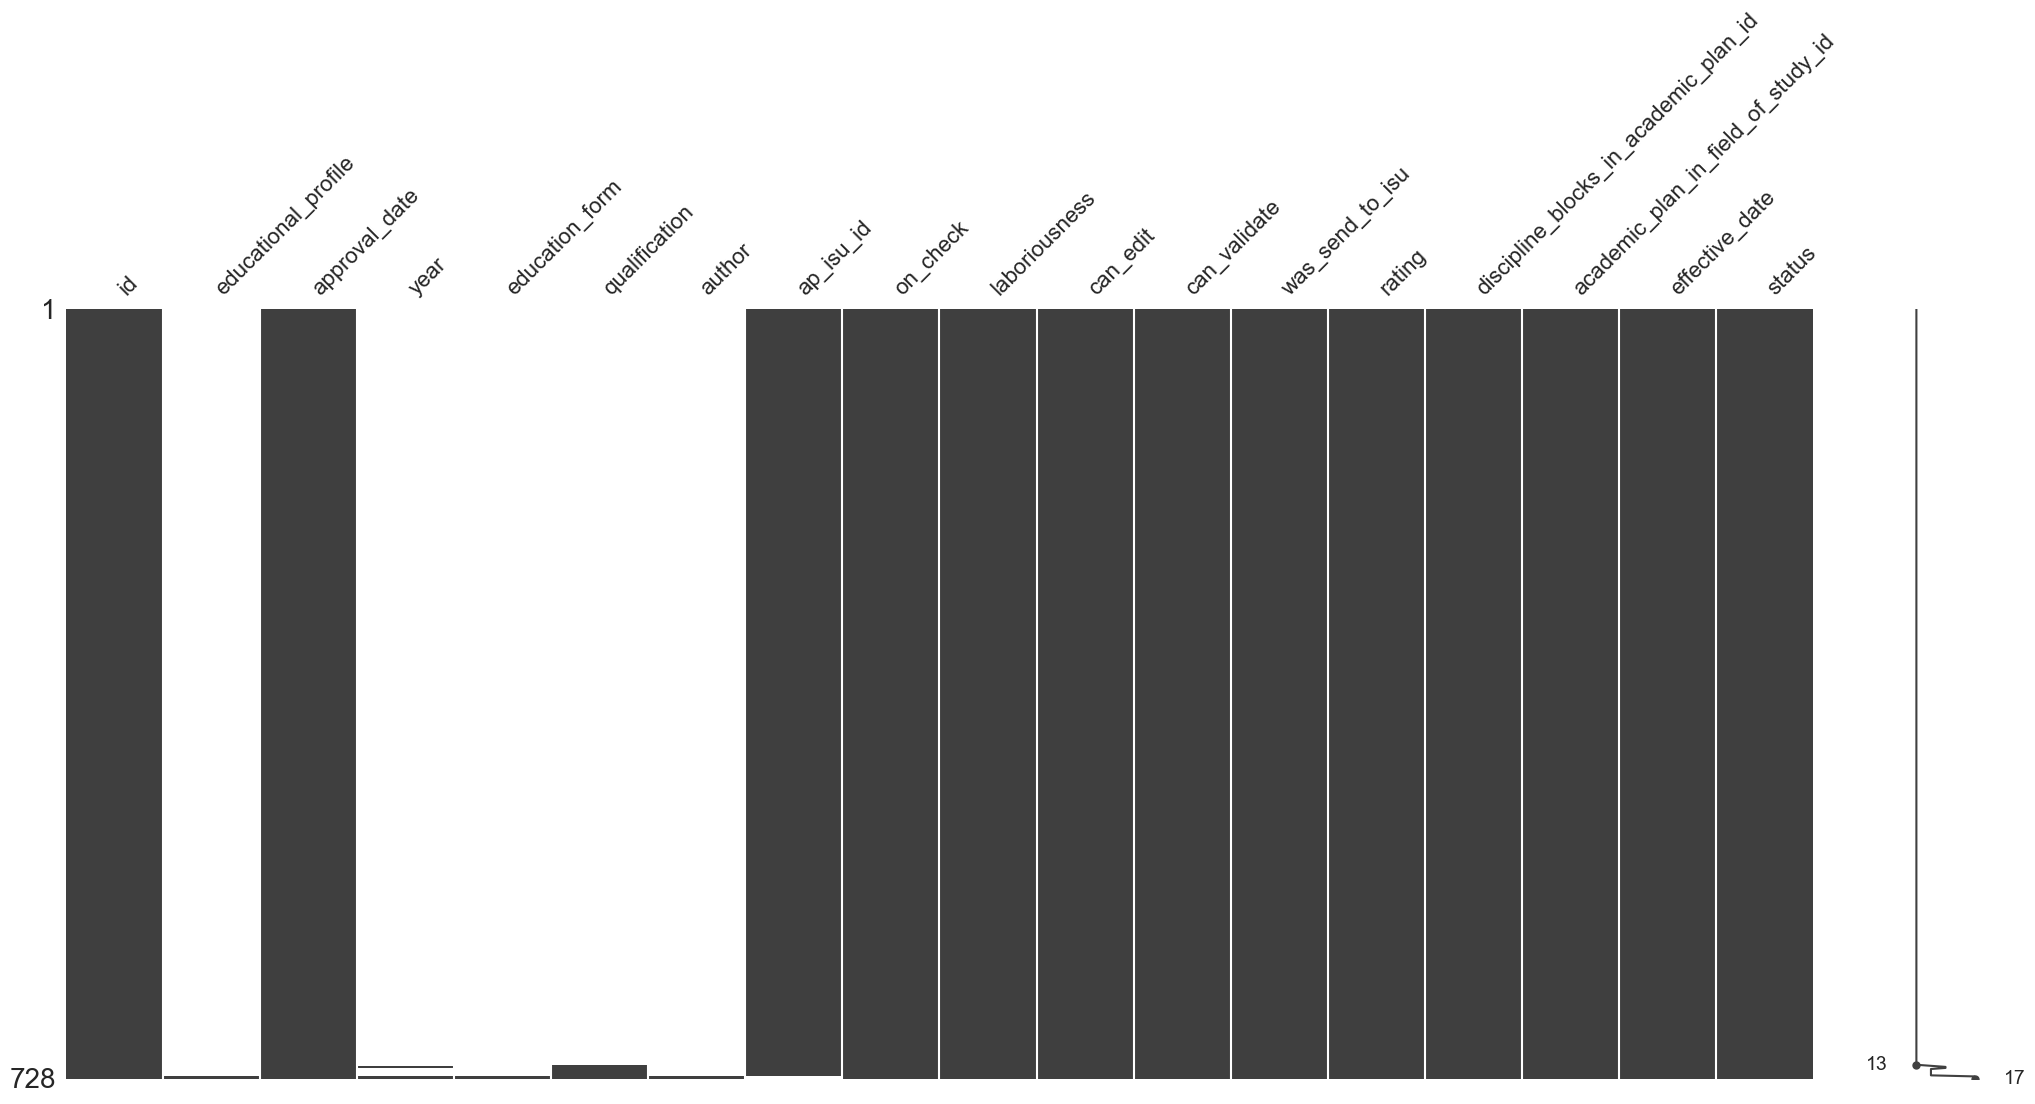

In [18]:
msno.matrix(data.dfs["academic_plans"])

## Выводы по полноте

academic_plans
- практически полностью отсутствует автор, год, educational profile, education form, qualification

academic_plans_in_field_of_study
- много пропусков в подразделениях
- есть пропуски в редакторах

structural_units
- всё ок

fields_of_study
- есть много пропусков в educational profile, факультете

editors
- много пропусков в почте

blocks
- в целом всё ок

modules
- есть небольшие пропуски в selection rule
- много пропусков в selection paramenter
- много пропусков в childs_ids, но это ок

change_blocks_of_work_programs_in_modules
- много пропусков в гиа и практики — это ок
- есть пропуски в кредитах

work_programs
- есть пропуски в авторах

gia
- много пропусков

practice
- много пропусков

## Уникальность

In [19]:
# Функция для выбора колонок
def get_cols_for_dups(df: pd.DataFrame, exclude_cols: None) -> list:
    df_cols = set(df.columns)
    if exclude_cols is None:
        exclude_cols = []
    exclude_cols = set(exclude_cols)
    df_cols = (df_cols - exclude_cols)
    return list(df_cols)

# Поиск дубликатов

duplicates = {}
exclude = {'zuns_for_wp', 'zuns_in_wp', 'change_blocks_of_work_programs_in_modules'}
check = list(set(data.dfs.keys()) - exclude)

for df_name in check:
    df = data.dfs[df_name].copy()

    current_cols = get_cols_for_dups(df, exclude_cols=['id', 'status', 'effective_date'])
    df = df[df.duplicated(subset=current_cols, keep=False)]
    df = df.dropna(how="all", axis=1)

    current_cols = get_cols_for_dups(df, exclude_cols=['id', 'status', 'effective_date'])
    df = df[df.duplicated(subset=current_cols, keep=False)]

    duplicates[df_name] = len(df)

duplicates

{'fields_of_study': 0,
 'structural_units': 0,
 'work_programs': 2,
 'academic_plans': 0,
 'editors': 0,
 'academic_plans_in_field_of_study': 61,
 'practice': 0,
 'modules': 522,
 'gia': 0,
 'blocks': 265}

## Постоянность

[Text(0.5, 1.0, 'Постоянность')]

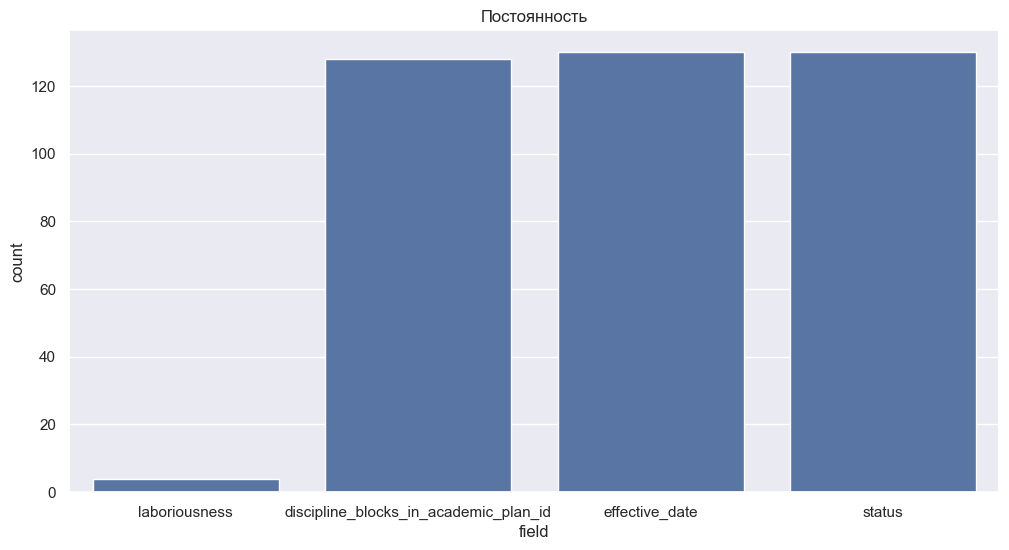

In [20]:
import seaborn as sns

table = 'academic_plans'

sns.set(rc={'figure.figsize':(12,6)})
changed_df = (data.dfs[table].groupby(by=['id']).nunique() - 1).replace(-1, 0).sum().reset_index()
changed_df = changed_df[changed_df[0] > 0]

changed_df = changed_df.rename({'index': 'field', 0: 'count'}, axis='columns')

sns.barplot(changed_df, x="field", y="count").set(title='Постоянность')

## Репзенетативность

После того как мы расписали мета данные, то смогли оценить такую характеристику как репрезентативность.

Практически все данные и поля интепретируемы и понятны. За исключением:
- значений в полях оценки ГИА
- значений в полях оценки Практики
- Некоторых значений зачетных единиц в семестр

Также большинство представлений выглядит логично и лаконично. Однако есть определенные поля, которые дублируются между таблицами и часто в одной из таблиц есть большое количество пропусков, а актуальная информация живет в другом месте. Также чрезмерно сложное представление имеют ГИА и Практика, наглядно это можно наблюдать ниже.

## Задание 2.3 Метаданные

Подготовьте наиболее полные метаданные по данным, полученным в задании 2.1

Данные содержатся в следующих таблицах

In [21]:
print('Tables:', *old_data.dfs.keys(), sep='\n-- ')

Tables:
-- academic_plans
-- academic_plans_in_field_of_study
-- structural_units
-- fields_of_study
-- editors
-- blocks
-- modules
-- change_blocks_of_work_programs_in_modules
-- work_programs
-- gia
-- practice
-- zuns_for_wp
-- zuns_in_wp


Чтобы получить данные, необходимо склонировать репозиторий https://github.com/evlko/CS-250/tree/main , заполнить .env файл валидными данными и выполнить команды `make load_devc`, `make set_dvc`. После этого соответствующие таблица появятся в папке data с расширением .csv

Изначально данные взяты с https://op.itmo.ru/api

Детальнее данные рассмотрим ниже:

In [22]:
from utils.data_info import DataInfo

In [23]:
dig = DataInfo.print_info_gen(data.dfs)

In [24]:
next(dig)

DATA INFO
academic_plans
Таблица с академическими планами.
	-id [Int, NOTNULL] - идентификатор академического плана
	-educational_profile [Str] - образовательный профиль
	-approval_date [Datetime, NOTNULL] - дата подтверждения программы
	-year [Int] - год академического плана
	-education_form [Str] - образовательная форма
	-qualification [Enum(bachelor, master)] - бразовательная квалификация
	-author [Int] - автор образовательного плана
	-ap_isu_id [Int] - идентификатор академического плана в ISU
	-on_check [Enum('in_work', 'on_check', 'verified'), NOTNULL] - статус академического плана
	-laboriousness [Int, NOTNULL] - трудоемкость
	-can_edit [Boolean, NOTNULL] - возможность редактировать для текущего пользователя
	-can_validate [Boolean, NOTNULL] - возможность валидировать для текущего пользователя
	-was_send_to_isu [Boolean, NOTNULL] - был ли отправлен план в ISU
	-rating [Boolean, NOTNULL] - всегда равен False, рейтинг АП
	-discipline_blocks_in_academic_plan_id [List, NOTNULL] - бло

,id,educational_profile,approval_date,year,education_form,qualification,author,ap_isu_id,on_check,laboriousness,can_edit,can_validate,was_send_to_isu,rating,discipline_blocks_in_academic_plan_id,academic_plan_in_field_of_study_id,effective_date,status
375,7200,NaN,2022-06-30T15:22:56.328099Z,NaN,NaN,NaN,NaN,16120.0,in_work,383,False,False,False,False,"[28604, 28606, 28607, 29013]",7263,10_10_2023,True
719,7499,NaN,2023-06-06T15:47:09.949952Z,NaN,NaN,master,NaN,28077.0,verified,120,False,False,True,False,"[30036, 30037, 30038, 30272]",7652,24_10_2023,True
122,6927,NaN,2022-06-30T15:03:29.759655Z,NaN,NaN,NaN,NaN,13264.0,in_work,621,False,False,False,False,"[27515, 27516, 27517, 28788]",6990,10_10_2023,True
350,7176,NaN,2022-06-30T15:21:38.324609Z,NaN,NaN,NaN,NaN,16014.0,in_work,526,False,False,False,False,"[28510, 28512, 28513, 28839]",7239,10_10_2023,True
466,7292,NaN,2022-11-30T20:04:16.709553Z,NaN,NaN,NaN,NaN,18337.0,verified,240,False,False,True,False,"[29302, 29303, 29304, 30205]",7356,24_10_2023,True


# Критерии и баллы

Распределение исходя из 30 баллов.



*   2.0 - 1 балл
*   2.1 - 8 баллов
*   2.2 - 12 баллов
*   2.3 - 9 баллов

